<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

# Wet and Dry Snow Dynamics in North Tyrol

## Data Preparation

The setup for the Wet/Dry Snow (WDS) analysis is the same as in previous notebooks.
WDS provides additional data to the snow extent identified by the FSC product, making the complexity of the analysis comparable to that of FSC.

In [ ]:
from pathlib import Path
import tarfile
import shutil
import tempfile
import time
import os
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    Geometry,SentinelHubDownloadClient,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
    MimeType,
    parse_time,
)

config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]
config.sh_base_url = "https://creodias.sentinel-hub.com"

### Loading Area of Interest

In [2]:
# Load in north tyrol
tyrol = gpd.read_file("../../data/raw/datacubes-snow-monitoring/input/north_tyrol.geojson")
# simplify geom to pass into payload 
tyrol_simple = tyrol.geometry.simplify(100)
geom = tyrol_simple[0]
geom_sh = Geometry(geom, CRS(3035))

### Defining Data Sources

Here, we define the data sources we will use. Specifically, we are utilizing the Wet/Dry Snow (WDS) product from the HR-S&I dataset, along with the digital elevation model and derived aspect values for Austria.

In [3]:
asp = DataCollection.define_byoc("fb426a12-f21d-4c9a-8848-eb4eca836bc9")
wds = DataCollection.define_byoc("02680a79-dba6-4eb5-a105-470472ece784")

### Helper Functions

These two helper functions facilitate making requests to the datacube and handling the data downloaded from those requests.

In [4]:
def get_request(
    input_data, 
    evalscript,
    geometry):
    """Specify Sentinel Hub Request

    Returns a Sentinel Hub Request based on some parameters.

    Params:
        input_data (SentinelHubRequest.input_data): an input data object
        evalscript (str): An evalscript to use in the request
        geometry (sentinelhub.Geometry): A sentinelhub.Geometry Object 
            representing the area of interest

    Returns:
        (sentinelhub.SentinelHubRequest) request with the passed in values set

    """
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[
            SentinelHubRequest.output_response("default", MimeType.TIFF), 
            SentinelHubRequest.output_response("userdata", MimeType.JSON)],
        geometry=geometry,
        config=config,
        resolution=(100,100),
        data_folder=tempfile.gettempdir()
    )

def get_data(request, downloaded_data, file_path, **kwargs):
    """Utility function to handle the downloaded data
    
    This function does a few things: 
    
    1. It gets the json from the downloaded data and 
    opens it into a pandas dataframe. 
    2. It moves the data saved locally to a permanent location
    specified in `file_path`
    3. It adds metadata to the pandas dataframe

    Params:
        request (sentinelhub.SentinelHubRequest): A
            Sentinelhubrequest
        downloaded_data (dict): The downloaded data from
            the request
        file_path (Union[str, PathLike]): File path where
            the image file from the request data should be 
            saved to
        **kwargs will be saved into the pandas dataframe
            where the keys are the column names and the
            values the values in the rows.
    
    Returns:
        (pd.DataFrame) A pandas dataframe built from the
            output of userdata.json
    
    """
    stats = downloaded_data["userdata.json"]

    # Move tif from zipped folder to outputs, rename and delete folder
    output = Path(tempfile.gettempdir()) / request.get_filename_list()[0]
    with tarfile.open(output, "r:") as tar:
        tar.extract("default.tif") 
    Path(file_path).parent.mkdir(parents=True, exist_ok=True) 
    Path("default.tif").replace(file_path)
    shutil.rmtree(output.parent)

    # Make the dataframe
    df = pd.DataFrame(stats).T.reset_index(names="class")
    # Split the class into its keys
    df[["aspect", "elevation_below"]] = df["class"].str.split("_", n=1, expand=True)
    # Make all columns given as kwargs
    df[list(kwargs.keys())] = list(kwargs.values())
    return df

### Querying the Datacube

Sentinel Hub functions as a raw datacube, providing access to vast amounts of complex data.

Since WDS is based on FSC data, the same general considerations and challenges apply. To quickly summarize:

- Large amounts of data: 
  - Each pixel has approximately 73 acquisitions per year.
  - For about 1.5 million pixels in Tyrol, this amounts to around 100 million unique data points per year that need to be handled.

- Irregular time series due to clouds and the acquisition schedule.

- Data mosaicking is required.

- This raw datacube can be efficiently queried to return analysis-ready data using Sentinel Hub Services.

#### Evalscript

The evalscript is very similar to the one used in the FSC analysis, with only the mosaicking strategy changed:

- Resample the data to the chosen resolution.

- Mosaic all available data points in the chosen time frame using a custom mosaicking strategy:
  - Pixels classified as wet snow at any point in the month are recorded as wet snow.
  - Pixels classified as dry snow at any point in the month, but never as wet snow, are recorded as dry snow.
  
- Return image statistics for different elevation and aspect classes.

For more information on how to build evalscripts see the [documentation](https://docs.sentinel-hub.com/api/latest/evalscript/).

In [5]:
with open("../../data/raw/datacubes-snow-monitoring/input/eval_wds.js", "r") as file:
    evalscript = file.read()

In [6]:
# This is the start and end of the period you want to check
# It will make monthly mosaics and output them into a folder
seasons = [2017, 2020]

out_paths = []
sh_requests = []
kwargs = []

for season in seasons:
    start = f"{season}-08-01"
    end = f" {season+1}-08-01"
    year_months = pd.date_range(start,end, 
                freq='MS').strftime("%Y-%m").tolist()
    for i in range(len(year_months)-1):
        input_data=[
                SentinelHubRequest.input_data(
                    data_collection=wds,
                    identifier="wds", 
                    time_interval=(f"{year_months[i]}-01", f"{year_months[i+1]}-01"),
                ),
                SentinelHubRequest.input_data(
                    data_collection=asp,
                    identifier="asp"
                )
            ]
        file_path = f"../../data/processing/datacubes-snow-monitoring/output/wds/wds_{year_months[i]}.tif"
        out_paths.append(file_path)
        request = get_request(input_data, evalscript, geom_sh)
        sh_requests.append(request)
        kwargs.append(dict(year_month=year_months[i], season=season))

In [ ]:
t0 = time.time()
# create a list of requests
dl_requests = [request.download_list[0] for request in sh_requests]

# download data with multiple threads
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)
dfs = [get_data(request, download, out_path, **kwarg) 
        for request, download, out_path, kwarg 
        in zip(sh_requests, downloaded_data, out_paths, kwargs)]
del downloaded_data

print(time.time()-t0)

In [ ]:
all_data = pd.concat(dfs)
all_data["percent_wet"] = all_data["wet"] / (all_data["dry"]+all_data["wet"])
all_data["km2_wet"] = (0.1*0.1)*all_data["wet"]
all_data["km2_dry"] = (0.1*0.1)*all_data["dry"]
all_data["km2_all"] = (0.1*0.1)*all_data["count"]
all_data[["year", "month"]] = all_data["year_month"].str.split("-", n=1, expand=True)
all_data.to_csv("../../data/processing/datacubes-snow-monitoring/output/wds_tyrol.csv")
all_data

## Analysis

The data retrieved from the requests above is ready for immediate analysis.

In [9]:
all_data = pd.read_csv("../../data/processing/datacubes-snow-monitoring/output/wds_tyrol.csv")

In [5]:
total = all_data.groupby(["season", "month"])[["dry", "wet"]].sum()
total["percent_wet"] = total["wet"] / (total["wet"]+total["dry"])
total

dry     wet  percent_wet
season month                             
2017   1      341701   71796     0.173631
       2      264355   26537     0.091226
       3      210064  109170     0.341975
       4       31147  313630     0.909660
       5        2200   67043     0.968228
       6        1070   23643     0.956703
       7        1405    7769     0.846850
       8        2074    8900     0.811008
       9       51409   89208     0.634404
       10      90389   57121     0.387235
       11     247670   81722     0.248100
       12     266984   81916     0.234784
2020   1      154530   98238     0.388649
       2      117754   74906     0.388799
       3      157568  167603     0.515430
       4      101600  187109     0.648089
       5       26742  233642     0.897298
       6        2339   79946     0.971574
       7         985   21141     0.955482
       8        1413   12668     0.899652
       9        3623   15327     0.808813
       10      28137   55760     0.664624
       11      62584  123620     0.663896
       12     114963   73308     0.389375

### Evolution of Wet/Dry Snow

Here, we compare the prevalence of wet snow in North Tyrol over two periods: August 2017 - July 2018 and August 2020 - July 2021.

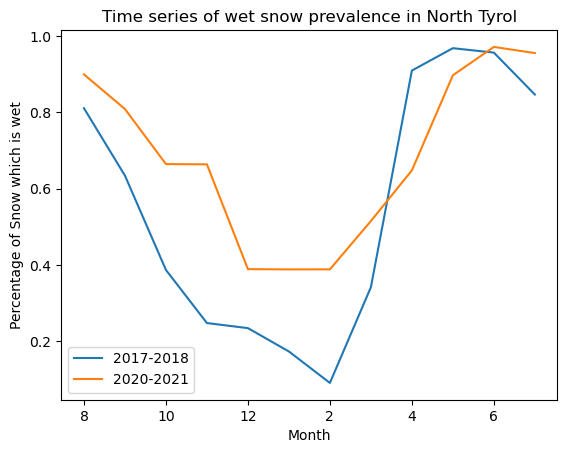

In [6]:
months = np.arange(1,13)
idx = np.roll(months, 7)
replace = {A: B for A, B in zip(months, idx)}

test = total["percent_wet"].unstack(level='season')
test["month"] = test.index
test.index = test.index.astype(str)
test["id"] = test["month"].replace(replace)
test.sort_values("id").plot(y=[2017, 2020], title="Time series of wet snow prevalence in North Tyrol", xlabel="Month", ylabel="Percentage of Snow which is wet")
plt.legend(['2017-2018','2020-2021']);

As expected, the chart shows that the ratio of wet to dry snow is higher in autumn and spring, whereas during the winter season, wet snow decreases due to temperatures below freezing in the mountains. However, the 2020-2021 season was much wetter throughout the peak of the snow season, with the percentage of wet snow never dropping below 40%.

### Impact of Elevation on Dry and Wet Snow

For this analysis, we again subset the data to areas between 1500-4000 meters in altitude, focusing solely on the 2020-2021 season.

In [7]:
# Elevation
elev_filtered = all_data.loc[np.logical_and.reduce((
    all_data.elevation_below < 4500, 
    all_data.elevation_below > 1500))]

elev = elev_filtered.groupby(["season","month", "elevation_below"])[["wet", "dry"]].sum()
elev["percent_wet"] = elev["wet"] / (elev["wet"]+elev["dry"])
elev_unstack = elev["percent_wet"].unstack(level=["elevation_below","season"])

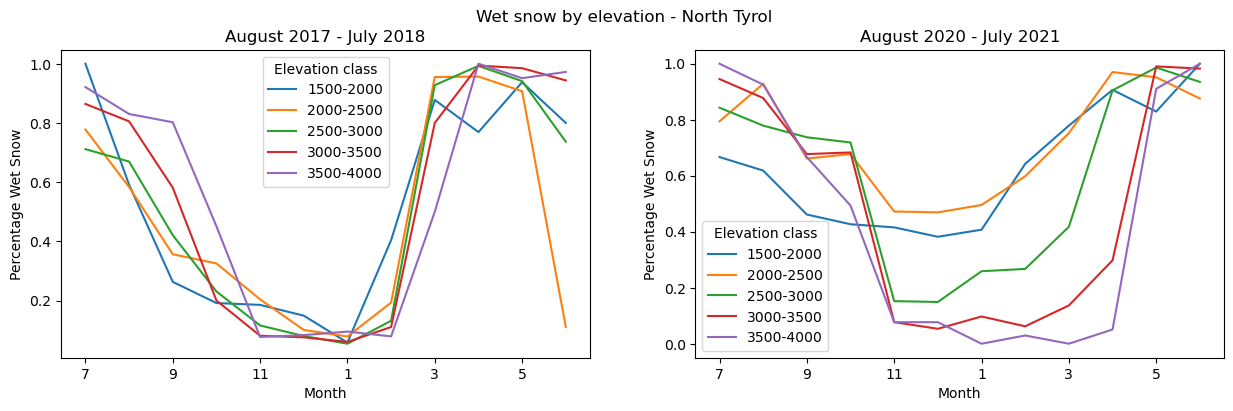

In [8]:
elev_plt = elev_unstack.reset_index()
elev_plt.index = elev_plt.index.astype(str)
elev_plt["id"] = elev_plt["month"].replace(replace)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
labels = dict(xlabel="Month", ylabel="Percentage Wet Snow")
elev_plt.sort_values("id").plot(y=[(2000, 2017), (2500, 2017),(3000, 2017), (3500, 2017),(4000, 2017)], ax=ax1, title="August 2017 - July 2018", **labels)
elev_plt.sort_values("id").plot(y=[(2000, 2020), (2500, 2020),(3000, 2020), (3500, 2020),(4000, 2020)], ax=ax2, title="August 2020 - July 2021", **labels)

ax1.legend(["1500-2000", "2000-2500", "2500-3000", "3000-3500", "3500-4000"], title = 'Elevation class');
ax2.legend(["1500-2000", "2000-2500", "2500-3000", "3000-3500", "3500-4000"], title = 'Elevation class');
fig.suptitle("Wet snow by elevation - North Tyrol");

We observe that before the start of the snow season, areas above 3000 masl had a higher percentage of wet snow, which dropped to around 10% during the winter season and gradually increased again.

Examining the elevation classes during the period of minimum snow cover, the ratio of dry snow is significantly higher compared to the 2020-2021 season, where there was more snow, but predominantly wet snow. This indicates that 2017-2018 was a drier year.

### Impact of Aspect on the Snow State

To analyze the impact of aspect on snow cover, we filtered the data to include only north- and south-facing slopes above 1500 meters.

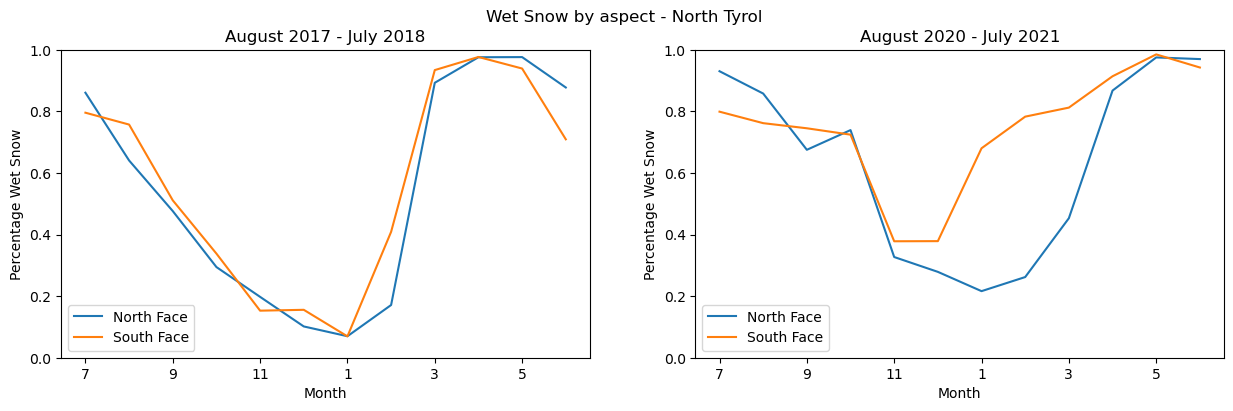

In [9]:
# Aspect
aspect_filtered = all_data.loc[np.logical_and(np.isin(all_data.aspect, [0,180]), all_data.elevation_below > 1500)]
aspect = aspect_filtered.groupby(["season", "month", "aspect"])[["wet", "dry"]].sum()
aspect["percent_wet"] = aspect["wet"] / (aspect["wet"]+aspect["dry"])
asp_unstack = aspect["percent_wet"].unstack(level=["aspect", "season"])

asp_plt = asp_unstack.reset_index()
asp_plt.index = asp_plt.index.astype(str)
asp_plt["id"] = asp_plt["month"].replace(replace)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
labels = dict(xlabel="Month", ylabel="Percentage Wet Snow")
asp_plt.sort_values("id").plot(y=[(0, 2017), (180, 2017)], ax=ax1, title="August 2017 - July 2018", ylim=(0,1), **labels)
asp_plt.sort_values("id").plot(y=[(0, 2020), (180, 2020)], ax=ax2, title="August 2020 - July 2021", ylim=(0,1), **labels)
ax1.legend(["North Face", "South Face"]);
ax2.legend(["North Face", "South Face"]);
fig.suptitle("Wet Snow by aspect - North Tyrol");

We observe that, particularly in the 2020-2021 period, north-facing slopes tend to have drier snow compared to south-facing slopes. However, during the 2017-2018 season, this difference is less pronounced.

Overall, the 2020-2021 period was wetter for both slope aspects compared to the 2017-2018 period.

The information obtained from these plots supports the findings from the distribution of wet snow by elevation class, further indicating that the 2017-2018 period was drier.

## Summary

- Overall, the ratio of wet snow was higher during the period of maximum snow cover (2020-2021), even in the winter season.

- Observations indicate that the 2017-2018 period was drier.

- So far, we have analyzed temporal time series, including topographic variables. However, we can gain further insights by examining what happened in other regions of Austria.